In [1]:
import sys
sys.path.insert(0, '../py')
from graviti import *

import json
import numpy as np
from skimage.draw import polygon
from skimage import io
from matplotlib import pyplot as plt
import glob
import pandas as pd
import os
from scipy.sparse import coo_matrix
from skimage.measure import label, regionprops
import math

import timeit
from datetime import datetime

patches = glob.glob('/home/garner1/pipelines/nucleAI/data/TCGA-05-4244-*.*.svs.tar.gz/luad_polygon/*/*.csv')

In [3]:
def get_mask_from_polygons(filename,x_list,y_list):
    if not (x_list and y_list):
        pass
    else:
        xx = np.array(x_list).reshape((len(x_list),1))
        yy = np.array(y_list).reshape((len(y_list),1))

        arr = np.hstack((xx,yy))

        # subtract the min to translate the mask                                                                                                                                                                   
        mini = np.min(arr,axis=0); arr -= mini

        rr = np.rint(arr[:,1]).astype(int) # xs are cols                                                                                                                                                           
        cc = np.rint(arr[:,0]).astype(int) # ys are rows                                                                                                                                                           
        mtx = coo_matrix((np.ones(rr.shape), (rr, cc)), dtype=bool)
        plt.figure(figsize=(40,40))
        io.imshow(mtx.todense(),cmap='gray')
        plt.savefig(filename+'.png')
    return mtx.todense()

In [4]:
def get_polygons_in_patch(filename):
    x_list = []
    y_list = []
    df = pd.read_csv(filename)
    if ~df.empty:
        cell_list = df['Polygon'].tolist()
        for cell in cell_list: # loop over cells in patch                                                                                                                                                          
            lista = list(np.fromstring(cell[1:-1], dtype=float, sep=':')) #list of vertices in polygon                                                                                                             
            cc = lista[0::2] # list of x coord of each polygon vertex                                                                                                                                              
            rr = lista[1::2] # list of y coord of each polygon verted                                                                                                                                              
            poly = np.asarray(list(zip(rr,cc)))
            mini = np.min(poly,axis=0)
            poly -= mini # subtract the min to translate the mask                                                                                                                                                  

            # create the nuclear mask                                                                                                                                                                              
            mask = np.zeros(tuple(np.ceil(np.max(poly,axis=0) - np.min(poly,axis=0)).astype(int)))
            rr, cc = polygon(poly[:, 0], poly[:, 1], mask.shape) # get the nonzero mask locations                                                                                                                  
            mask[rr, cc] = 1 # nonzero pixel entries                                                                                                                                                               
            # rescale back to original coordinates                                                                                                                                                                 
            rr = rr.astype(float);cc = cc.astype(float)
            rr += mini[0]; cc += mini[1]

            # update the list of nonzero pixel entries                                                                                                                                                             
            x_list.extend( [int(n) for n in list(cc)] )
            y_list.extend( [int(n) for n in list(rr)] )
        mask = get_mask_from_polygons(filename,x_list,y_list)
    return mask

['44001_8001_2330_4000_0.2325_1-features.csv']
The patch is empty
['8001_16001_4000_4000_0.2325_1-features.csv']


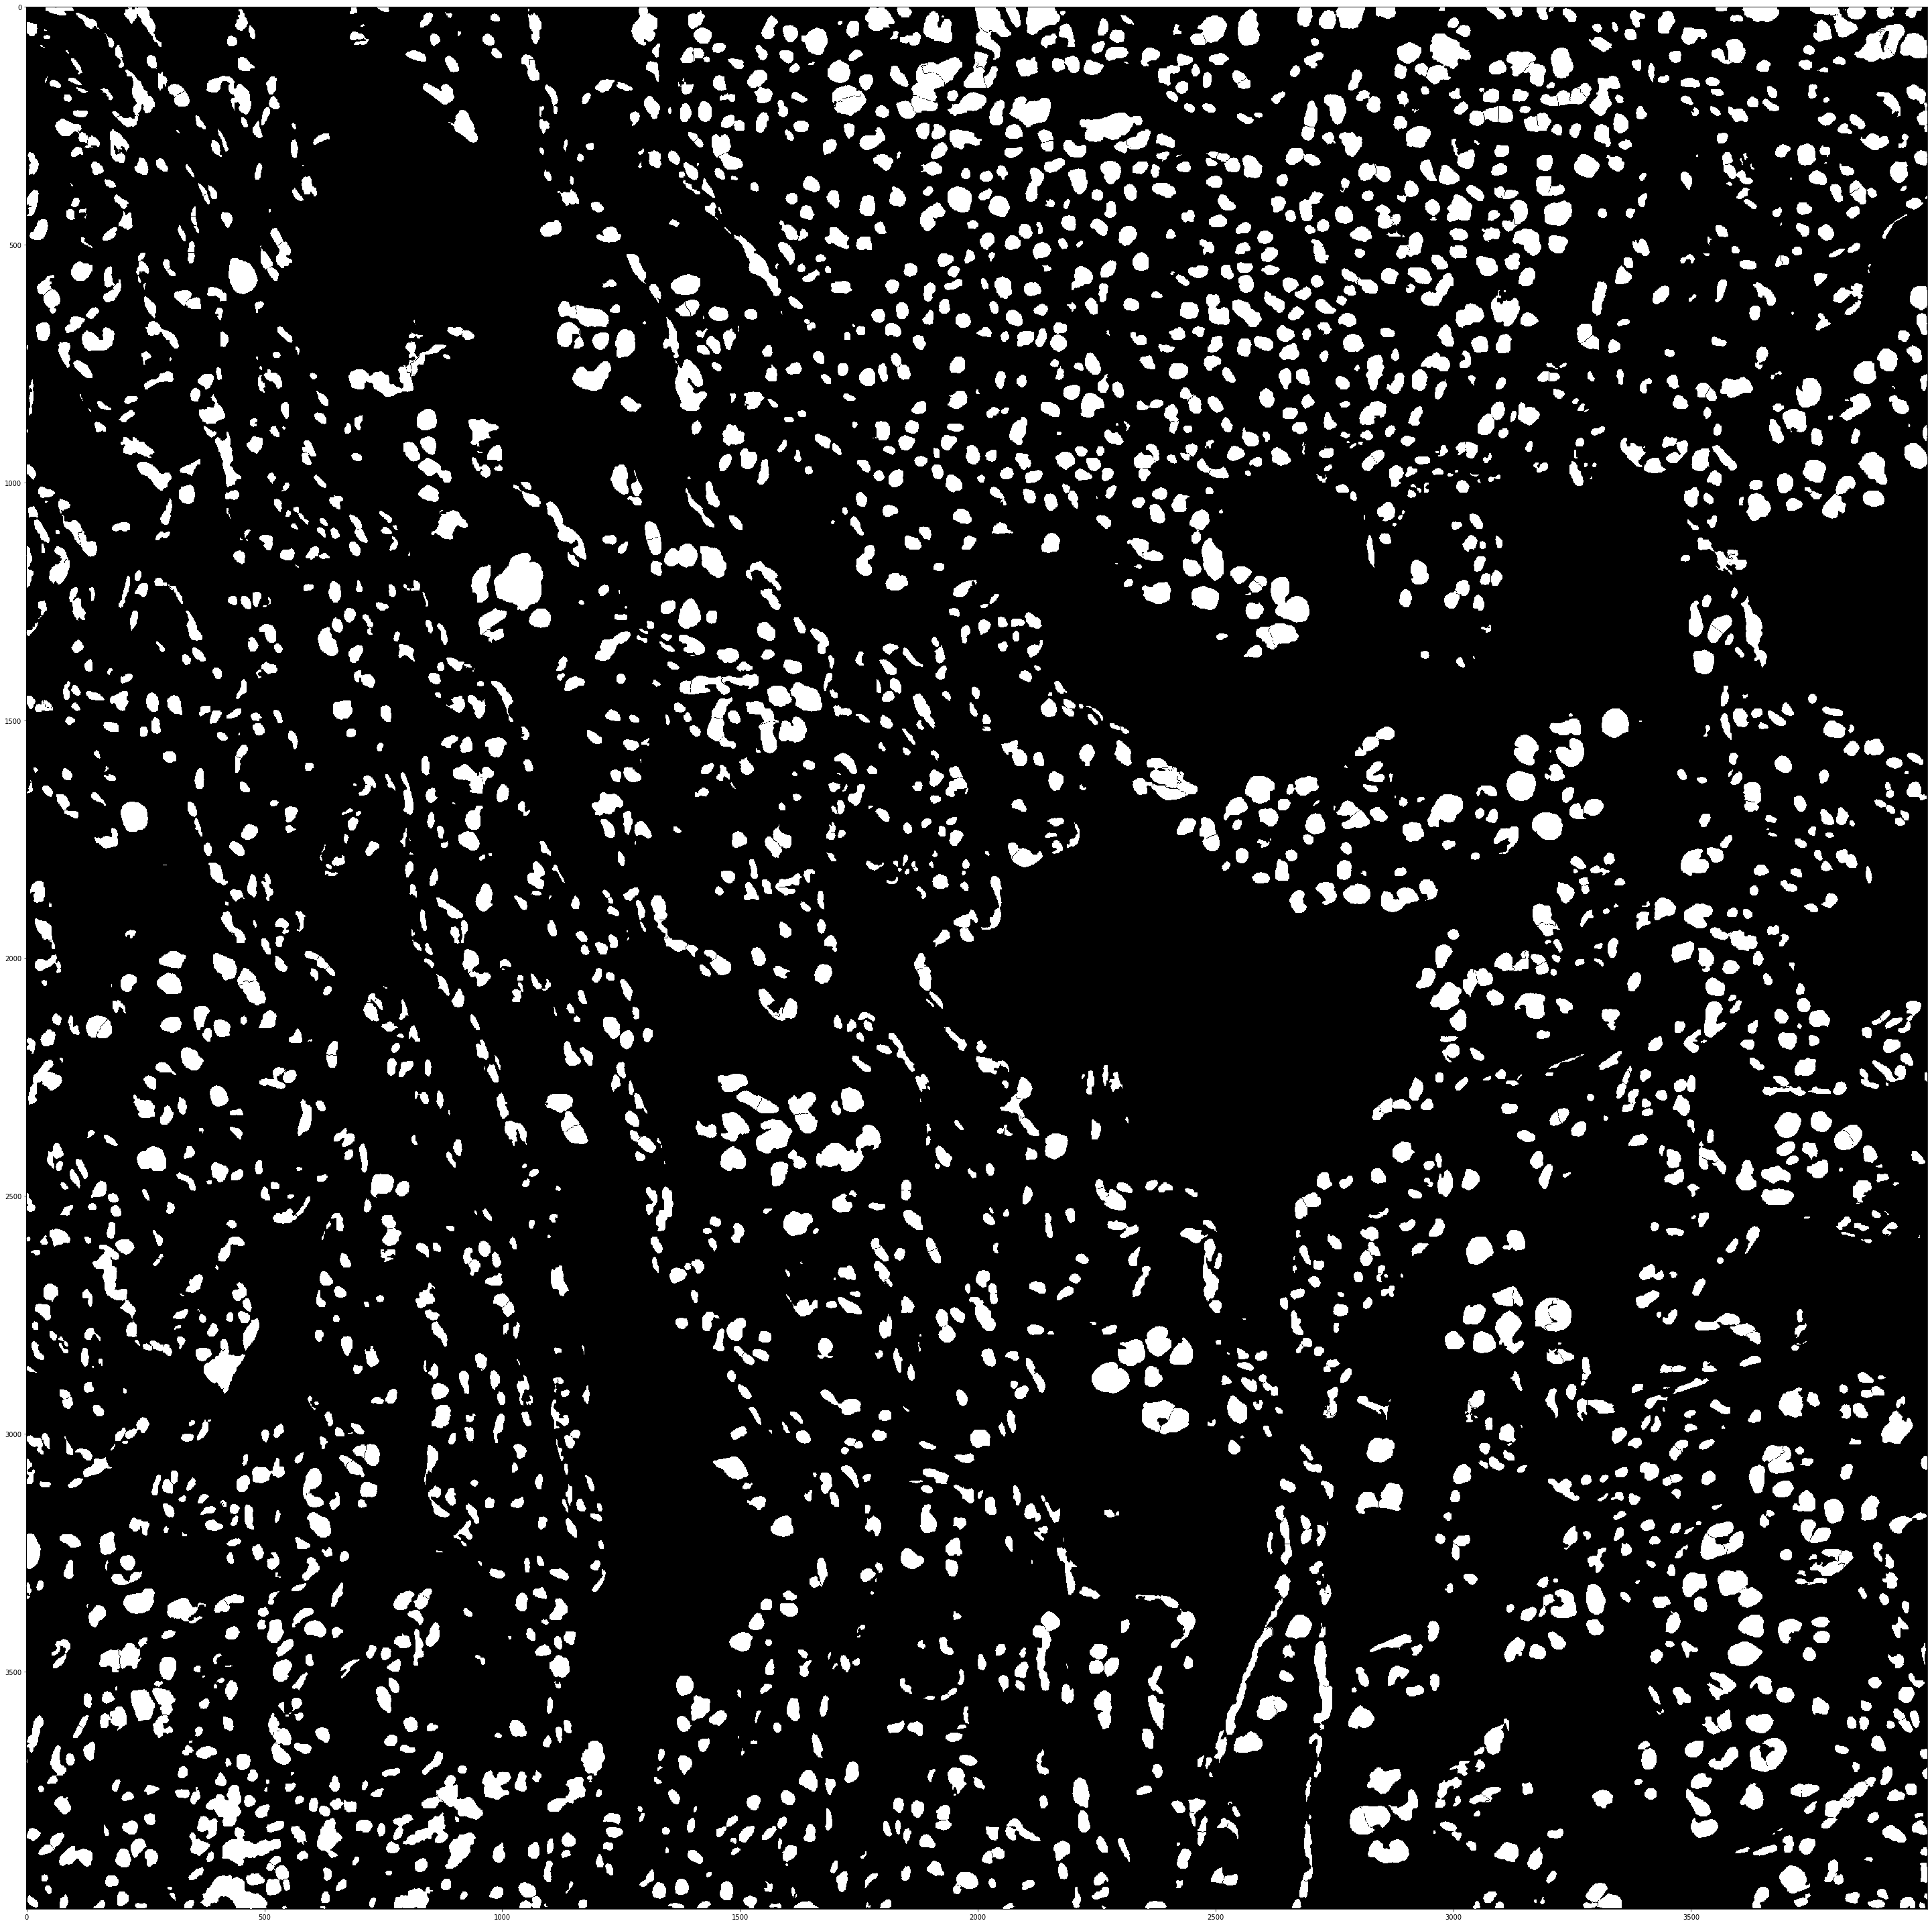

In [5]:
# print('Showing the patches as png files...')                                                                                                                                                                     
for patch in patches[:2]:
    print(patch.split('/')[9:])
    if not pd.read_csv(patch).empty:
        mask = get_polygons_in_patch(patch)
    else:
        print('The patch is empty')

In [6]:
import pyvips
image = pyvips.Image.new_from_file("/home/garner1/pipelines/nucleAI/data/TCGA-05-4244-01Z-00-DX1.d4ff32cd-38cf-40ea-8213-45c2b100ac01.svs")
tile = image.crop(8001,16001,mask.shape[1],mask.shape[0])
tile.write_to_file('patch.jpg[Q=95]')

In [7]:
#from IPython.display import Image
#Image(filename='patch.jpg') 

In [8]:
import cv2
img = cv2.imread('patch.jpg')
#plt.imshow(img)
#print(img.shape,mask3d.shape)

#mask = cv2.imread('/home/garner1/pipelines/nucleAI/data/TCGA-05-4244-01Z-00-DX1.d4ff32cd-38cf-40ea-8213-45c2b100ac01.svs.tar.gz/luad_polygon/TCGA-05-4244-01Z-00-DX1.d4ff32cd-38cf-40ea-8213-45c2b100ac01.svs/8001_16001_4000_4000_0.2325_1-features.csv.png',0)
#res = cv2.bitwise_and(img,img,mask = mask3d)

In [9]:
from __future__ import print_function

import histomicstk as htk

import numpy as np
import scipy as sp

import skimage.io
import skimage.measure
import skimage.color

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

#Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 15, 15
plt.rcParams['image.cmap'] = 'gray'
titlesize = 24

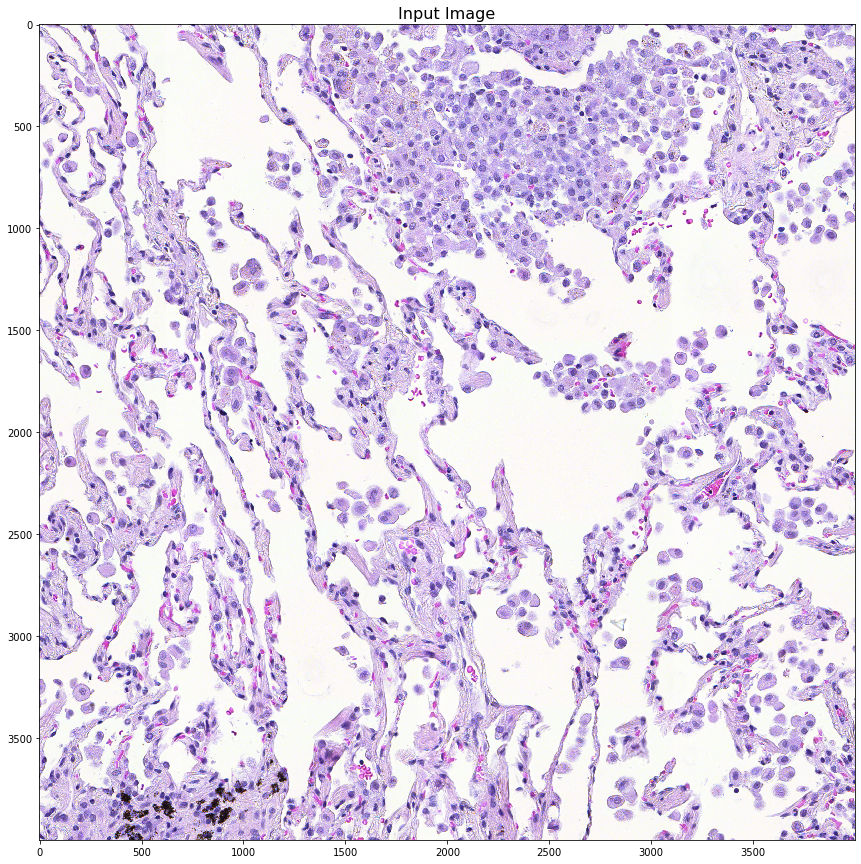

In [10]:
inputImageFile = ('patch.jpg')  # H&E.png

imInput = skimage.io.imread(inputImageFile)[:, :, :3]

plt.imshow(imInput)
_ = plt.title('Input Image', fontsize=16)

stain_color_map:
{'hematoxylin': [0.65, 0.7, 0.29], 'eosin': [0.07, 0.99, 0.11], 'dab': [0.27, 0.57, 0.78], 'null': [0.0, 0.0, 0.0]}


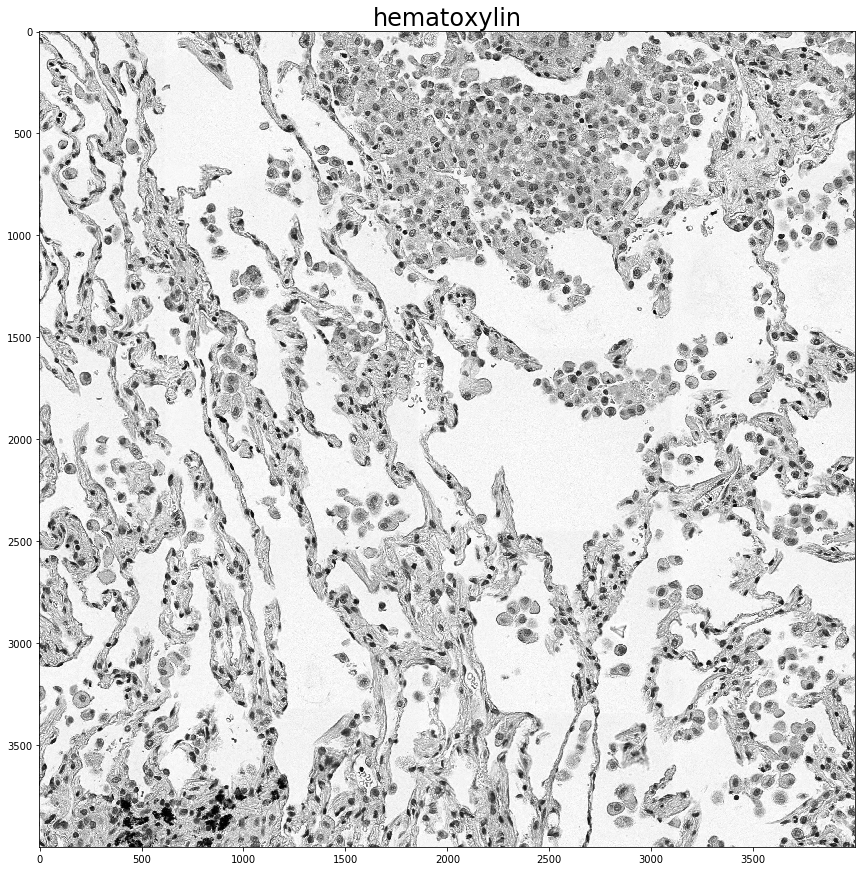

In [10]:
# create stain to color map
stain_color_map = htk.preprocessing.color_deconvolution.stain_color_map
print('stain_color_map:', stain_color_map, sep='\n')

# specify stains of input image
stains = ['hematoxylin',  # nuclei stain
          'eosin',        # cytoplasm stain
          'null']         # set to null if input contains only two stains

# create stain matrix
W = np.array([stain_color_map[st] for st in stains]).T

# perform standard color deconvolution
imDeconvolved = htk.preprocessing.color_deconvolution.color_deconvolution(imInput, W)

# Display results
for i in [0]:#, 1:
    plt.figure()
    plt.imshow(imDeconvolved.Stains[:, :, i])
    _ = plt.title(stains[i], fontsize=titlesize)

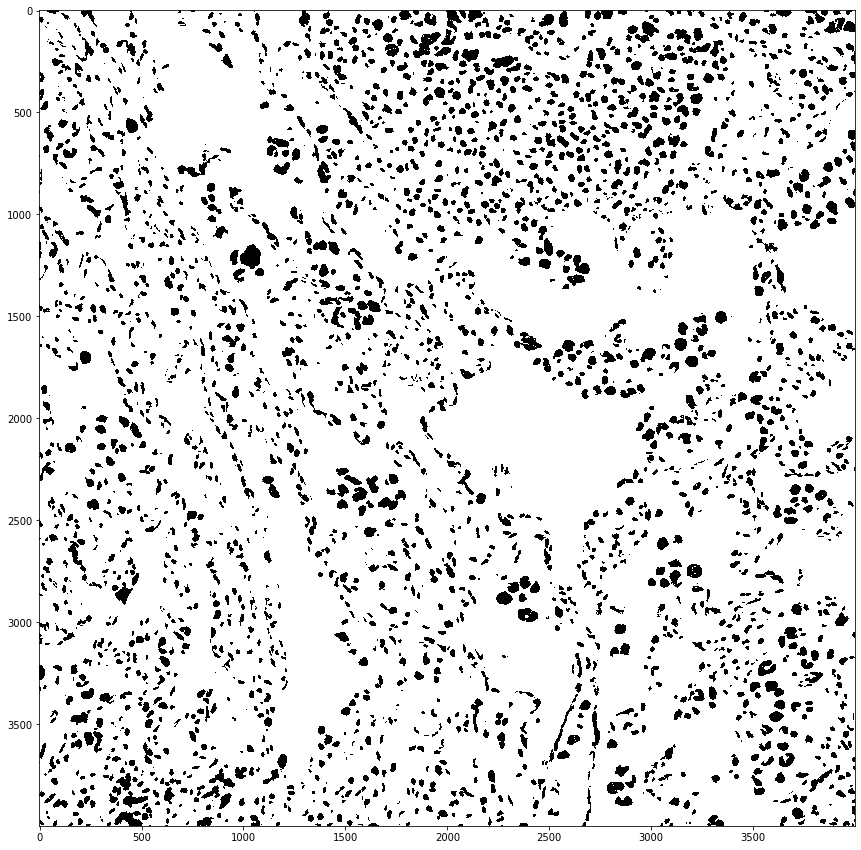

In [11]:
plt.figure()
masked = np.multiply(imDeconvolved.Stains[:, :, 0],~mask)
plt.imshow(masked>1)

In [ ]:
labels, num = label(mask, return_num=True, connectivity=1) # connectivity has to be 1

for l in range(2748,num+1)[:]: # for every nucleus
    maska = labels == l # get the mask
    if maska.nonzero()[0].shape[0] > 200: # condition on size
        # Repeat over the third axis of the image
        masked = np.multiply(imInput[:,:, 0],maska)
        norows = masked[~np.all(masked == 0, axis=1)] #remove 0 rows
        arr0 = norows[:,~(norows == 0).all(0)] # remove 0 cols
        
        masked = np.multiply(imInput[:,:, 1],maska)
        norows = masked[~np.all(masked == 0, axis=1)] #remove 0 rows
        arr1 = norows[:,~(norows == 0).all(0)] # remove 0 cols

        masked = np.multiply(imInput[:,:, 2],maska)
        norows = masked[~np.all(masked == 0, axis=1)] #remove 0 rows
        arr2 = norows[:,~(norows == 0).all(0)] # remove 0 cols

        arr_3d = np.dstack((arr0,arr1,arr2))
        plt.figure()
        plt.imshow(arr_3d)
        plt.savefig('./single_nuclei/nucleus_'+str(l)+'.png')

In [12]:
labels, num = label(mask, return_num=True, connectivity=1) # connectivity has to be 1
print(num)
labels, num = label(mask, return_num=True, connectivity=None) # connectivity has to be 1
print(num)

3355
2956
